In [19]:
!pip install vaderSentiment

In [57]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [58]:
data=pd.read_csv(r"C:\Users\shubh\Desktop\Deep Learning-- NLP\NLP\IPL2020_Tweets.csv")
data.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,month,year
0,GAURAV DHANAWAT 🇮🇳,"Delhi,India",Live EVS Operator/Coordinator | EX Ten Sports ...,02/04/09 17:06,147.0,127.0,205.0,False,2020-11-11,Time to change the Bubble from #IPL2020 to #IS...,"['IPL2020', 'ISL2020']",Twitter for iPhone,False,11.0,2020.0
1,🇮🇳🇮🇳 शुभम दोहरे 🇮🇳🇮🇳,"Bhopal, India",👉💯%Bhopali😎\n👉B+🔥\n👉Proud to be an #indian🇮🇳\n...,10/11/16 5:09,113.0,699.0,1412.0,False,2020-11-11,Why is #2020Fixing trending?? \n\nI think rcb ...,['2020Fixing'],Twitter for Android,False,11.0,2020.0
2,Steven Gordon,"Carrickfergus, Northern Irelan","Buns are good but puns are better, best served...",03/04/13 15:03,27.0,57.0,41.0,False,2020-11-11,@ICC And still #rajasthanroyals finished last...,"['rajasthanroyals', 'JofraArcher', 'RR', 'jofr...",Twitter for Android,False,11.0,2020.0
3,Bhumish Patel,Montreal Canada,"Student at Concordia University, Montreal, CA\...",04/07/13 16:24,131.0,1525.0,10343.0,False,2020-11-11,I still remember the bus parade after @mipalta...,NaN,Twitter Web App,False,11.0,2020.0
4,cricket22yards,NaN,We are a cricketing blog highly focusing on th...,02/09/16 19:14,551.0,189.0,160.0,False,2020-11-11,"#IPL2020 \n\nSTATS: Most runs, fastest fifties...",['IPL2020'],Twitter Web App,False,11.0,2020.0


In [23]:
data.shape

(572963, 15)

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572963 entries, 0 to 572962
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_name         572963 non-null  object 
 1   user_location     430627 non-null  object 
 2   user_description  525288 non-null  object 
 3   user_created      572963 non-null  object 
 4   user_followers    572963 non-null  float64
 5   user_friends      572963 non-null  float64
 6   user_favourites   572963 non-null  float64
 7   user_verified     572963 non-null  bool   
 8   date              572963 non-null  object 
 9   text              572963 non-null  object 
 10  hashtags          462876 non-null  object 
 11  source            572849 non-null  object 
 12  is_retweet        572959 non-null  object 
 13  month             572963 non-null  float64
 14  year              572963 non-null  float64
dtypes: bool(1), float64(5), object(9)
memory usage: 61.7+ MB


In [25]:
data.isnull().sum()

user_name                0
user_location       142336
user_description     47675
user_created             0
user_followers           0
user_friends             0
user_favourites          0
user_verified            0
date                     0
text                     0
hashtags            110087
source                 114
is_retweet               4
month                    0
year                     0
dtype: int64

We can see that some tweets dont involve any hashtags. Also for some the user location and description and source of tweet is missing, but text column which is required for sentiment analysis doesn't contain any null values

In [26]:
data['senttext'] = data['text']

### Converting all the data to lowercase

In [27]:
df = data.apply(lambda x: x.astype(str).str.lower())

<AxesSubplot:>

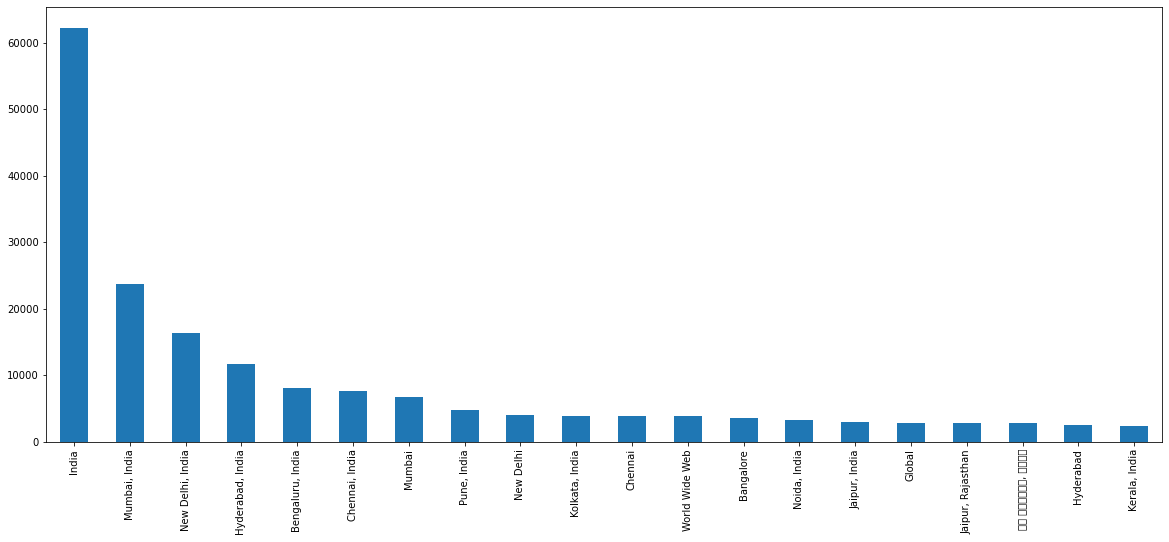

In [28]:
loc_df = data[data.user_location != 'nan']
loc_df.user_location.value_counts().nlargest(20).plot(kind='bar',figsize=(20,8))

Indian cities dominate the top 20 user locations as expected. 'global' and 'worldwide' locations also make it in top 20

In [29]:
indian_cities = {}
indian_metros = ['mumbai', 'bangalore', 'delhi', 'kolkata', 'chennai', 'ahmedabad', 'hyderabad']
for city in indian_metros: 
    indian_cities[city] = df.user_location.str.count(city).sum()

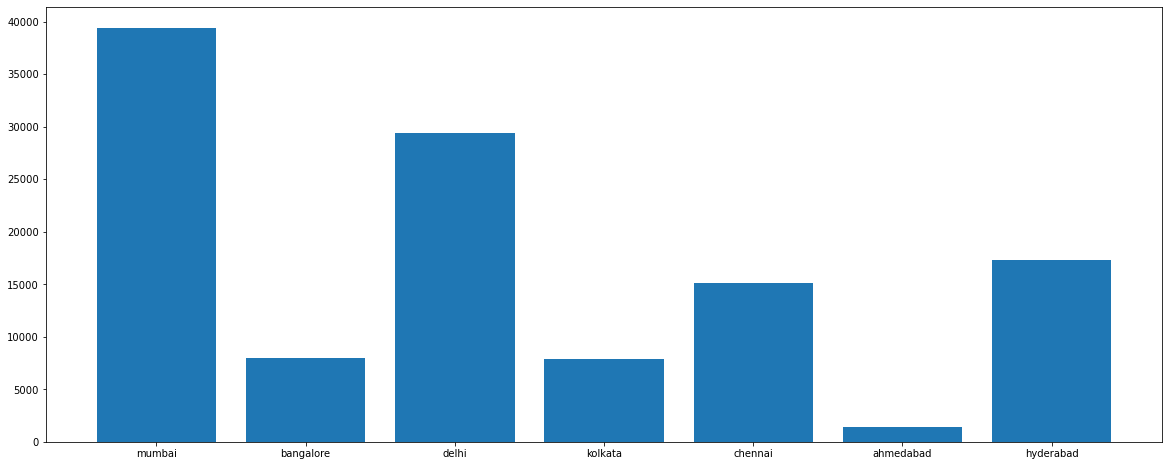

In [32]:
plt.figure(figsize=(20, 8))
plt.bar(*zip(*indian_cities.items()))

plt.show()

Users in Indian metro cities who have teams in IPL are most active. Other cities like Ahmedabad have much less tweets

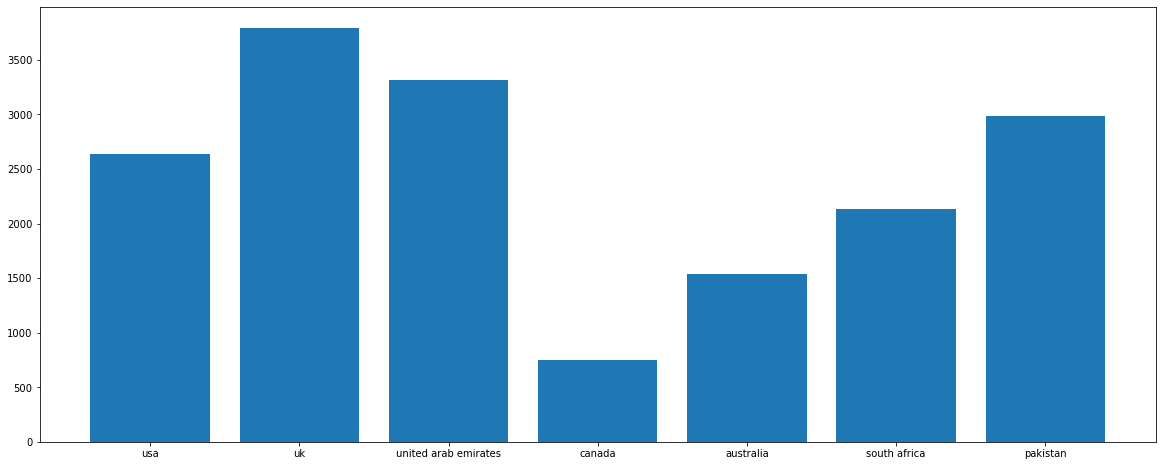

In [31]:
ipl_countries = {}
countries = ['usa', 'uk', 'united arab emirates', 'canada', 'australia', 'south africa', 'pakistan']
for country in countries: 
    ipl_countries[country] = df.user_location.str.count(country).sum()

    
plt.figure(figsize=(20, 8))
plt.bar(*zip(*ipl_countries.items()))

plt.show()

Comparing tweets from countries with top cricket teams and where indian population is high

<AxesSubplot:>

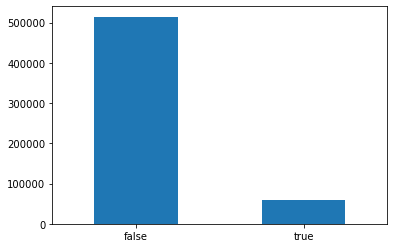

In [33]:
df.user_verified.value_counts().plot(kind='bar', rot=0)

Most of the users are not verified on twitter

<AxesSubplot:>

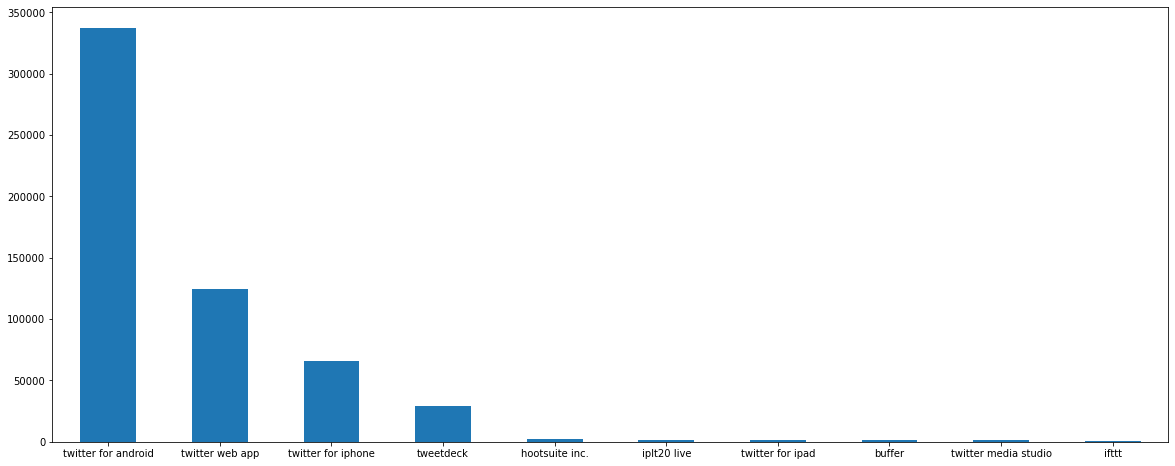

In [34]:
df.source.value_counts().nlargest(10).plot(kind='bar', rot=0, figsize=(20,8))

Users used twitter app on android the most. iPhone users come after Website/app users

<AxesSubplot:>

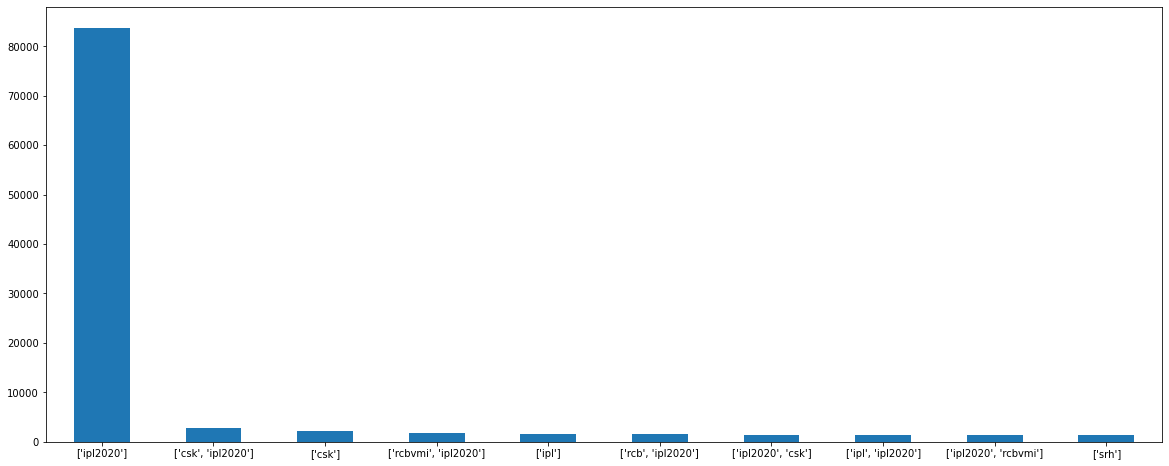

In [35]:
hashtag_df = df[df.hashtags != 'nan']
hashtag_df.hashtags.value_counts().nlargest(10).plot(kind='bar', rot=0, figsize=(20,8))

People used the tournament hashtag the most, with some specific match based and team hashtags also making an appearance

## Removing all the stop words, mentions, hashtags and URLs to create a word cloud

In [37]:
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
df.text = df.text.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [38]:
df.text = df.text.apply(lambda x: ' '.join(re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)", " ", x).split()))

In [39]:
df.text = df.text.apply(lambda x: ' '.join(re.sub("[\.\,\!\?\:\;\-\=]", " ", x).split()))

In [40]:
df.text = df.text.apply(lambda x: ' '.join(re.sub(r'http\S+', '', x).split()))

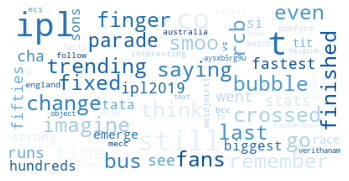

In [41]:
wordcloud = WordCloud(
                          background_color='white',
                          colormap='Blues',
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(df['text']))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Time wise plot of all tweets

In [42]:
df['tweet_date']=pd.to_datetime(df['date']).dt.date
tweet_date=df['tweet_date'].value_counts().to_frame().reset_index().rename(columns={'index':'date','tweet_date':'count'})
tweet_date['date']=pd.to_datetime(tweet_date['date'])
tweet_date=tweet_date.sort_values('date',ascending=False)

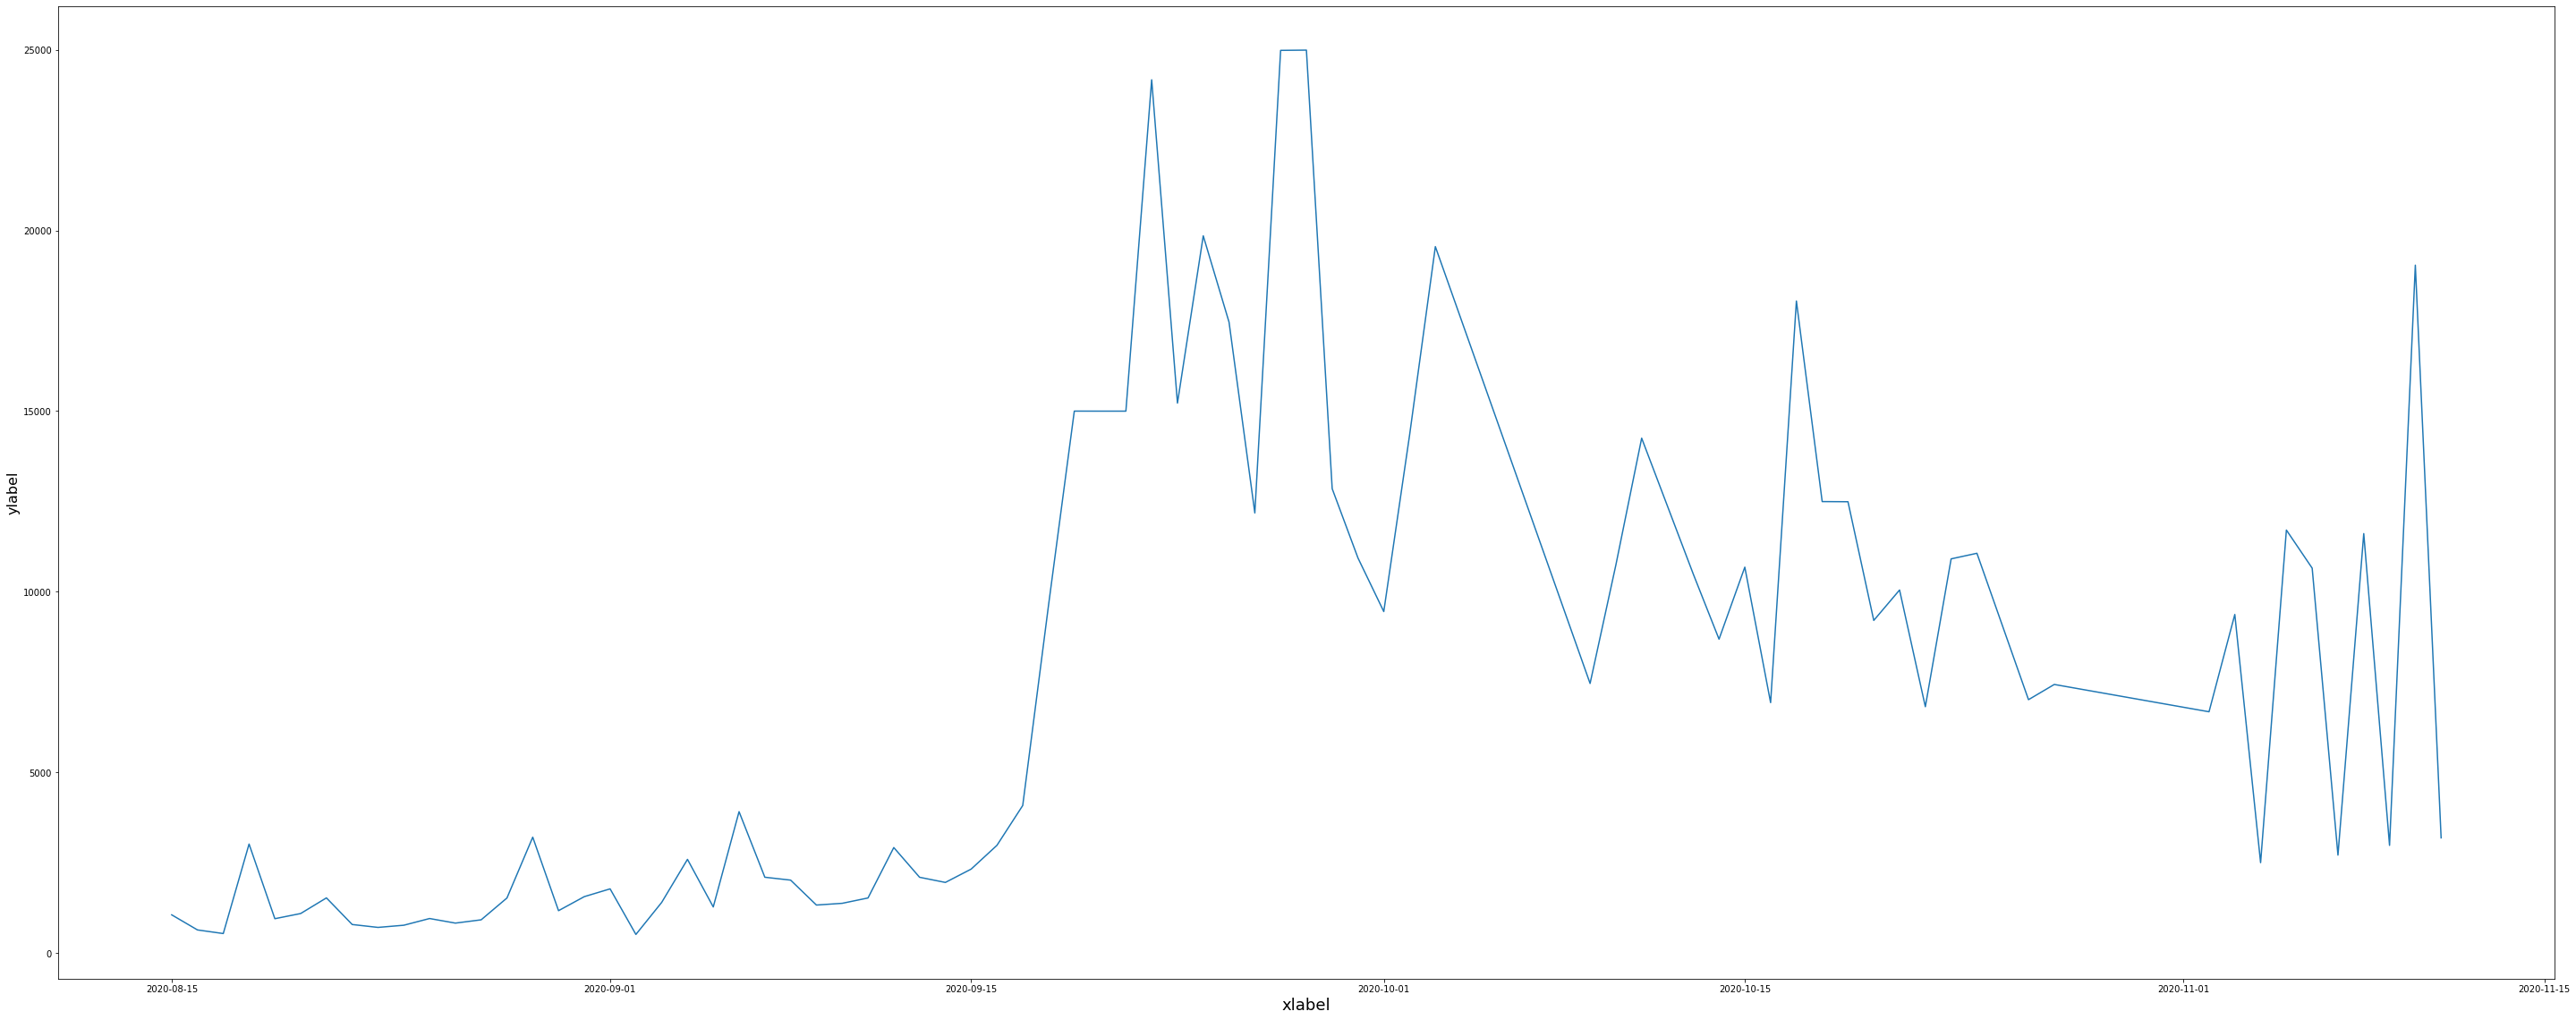

In [43]:
plt.figure (figsize=(50,20))
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=16)
plt.plot(tweet_date['date'], tweet_date['count'])

Tweets started flowing in when the tournament announcement was made, and saw a steep increase once the tournament started

## Replacing the emojis with unicode

In [44]:
try:
    # UCS-4
    e = re.compile(u'[\U00010000-\U0010ffff]')
except re.error:
    # UCS-2
    e = re.compile(u'[\uD800-\uDBFF][\uDC00-\uDFFF]')
emojis = []
for x in df.text:
    match  = e.search(x)
    if match:
        emojis.append(match.group())

### Top 10 Emojis used in tweets

In [45]:
dfe =  pd.DataFrame(emojis,columns=['text'])
pd.Series(' '.join(dfe['text']).lower().split()).value_counts()[:10]

🔥    16774
😂     9357
😍     6329
🏏     5224
👏     5216
💥     3682
😎     3517
👇     2795
🙏     2780
👍     2762
dtype: int64

## Find out similar words

In [51]:
num_features = 400    # Word vector dimensionality                      
min_word_count = 5   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

wt = [list(x.split()) for x in df.text]
from gensim.models import word2vec
print ("Training model...")
wv_model = word2vec.Word2Vec(wt, workers=num_workers, \
            window = context, sample = downsampling)

wv_model.init_sims(replace=True)

Training model...


In [ ]:
num_features = 400    # Word vector dimensionality                      
min_word_count = 5   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

wt = [list(x.split()) for x in df.text]
from gensim.models import word2vec
print ("Training model...")
wv_model = word2vec.Word2Vec(wt, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

wv_model.init_sims(replace=True

## Now applying the VADER sentiment analyzer

In [54]:
analyser = SentimentIntensityAnalyzer()

df['sentiment_score'] = df['senttext'].apply(lambda x: analyser.polarity_scores(str(x)))

In [55]:
def sentiment_func(sentiment):
#     print(s['pos'])
    for k,v in sentiment.items():
        if (k == 'pos' or k or 'neg' or k == 'neu') == True:
            if (sentiment['pos'] > 0.5 and sentiment['neg'] < 0.5 and sentiment['neu'] < 0.5) == True:
                return 'positive'
            elif (sentiment['pos'] < 0.5 and sentiment['neg'] > 0.5 and sentiment['neu'] < 0.5) == True:
                return 'negative'
            elif (sentiment['pos'] < 0.5 and sentiment['neg'] < 0.5 and sentiment['neu'] > 0.5) == True:
                return 'neutral'

df['sentiment'] = df['sentiment_score'].apply(sentiment_func)

<AxesSubplot:>

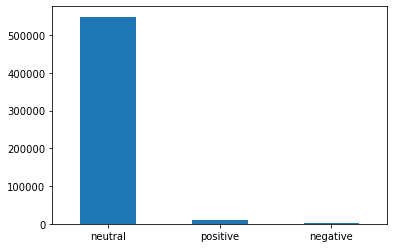

In [56]:
df.sentiment.value_counts().plot(kind='bar', rot=0)

Most the tweets are neutral. This can be due to most tweets just containing score updates or match updates.
Number of positive tweets are more than negative. Seems like people were very happy with tournament happening at such difficult time and people got excited and happy to see their favorite cricketers back on pitch.